<a href="https://colab.research.google.com/github/henriquehorton/desempenho-de-ferramentas-cl-nicas/blob/main/volume_de_ar_e_analise_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configurações Iniciais

##Instalando dependências

In [ ]:
# Instalando dependências
!pip install pydicom
!pip install opencv-python 

##Carregando bibliotecas que serão necessárias

In [ ]:
import pydicom
import cv2
import pandas as pd 
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.express as px
from glob import glob
from os.path import join

# Funções

##Listar Arquivos do diretório

In [ ]:
def listar_pasta(pasta):
  lista = []
  path = join(pasta, '*')
  for i in sorted(glob(path)):
    dataset = pydicom.dcmread(i)
    lista.append(dataset)
  return lista

##Segmentar Imagens

In [ ]:
def segmentar_imagens(pasta, max_value, raio):

  # Listar diretório
  arquivos = listar_pasta(pasta)  

  biblioteca = {'id':[], 'imagem':[], 'mascara':[], 'imagem segmentada':[],
                'fatia do corte':[]}

  count = 1
  for i in arquivos:

    #Rescalando valores de HU
    img_pixel = (i.pixel_array*i.RescaleSlope)+i.RescaleIntercept  

    # Isolar centro da imagem
    img1_bin = (img_pixel < max_value) * 1
    mascara = np.zeros(img1_bin.shape[:2], dtype = "uint8")
    (cX, cY) = (img1_bin.shape[1] // 2, img1_bin.shape[0] // 2)
    cv2.circle(mascara, (cX, cY), 180, 255, -1)
    centro_img = cv2.bitwise_and(img1_bin, img1_bin, mask = mascara)
    
    # preparar segmentação
    kernel = np.ones(raio,np.uint8)

    # precesso de abertura da imagem
    img1_isolada = centro_img.astype('uint8')
    img1_aberta = cv2.morphologyEx(img1_isolada, cv2.MORPH_OPEN, kernel)

    # processo de fechamento da imagem
    img1_aberta = img1_aberta.astype('uint8')
    img1_fechada = cv2.morphologyEx(img1_aberta, cv2.MORPH_CLOSE, kernel)

    # Máscara da segmentação
    img_mascara = ((img1_fechada * img_pixel)< max_value)*1

    # Imagem segmentada
    img_segmentada = (img_mascara * img_pixel)

    
    # Populando e criando dataframe
    biblioteca['id'].append(count)
    biblioteca['imagem'].append(img_pixel)
    biblioteca['mascara'].append(img_mascara)
    biblioteca['imagem segmentada'].append(img_segmentada)
    biblioteca['fatia do corte'].append(i.SliceLocation)    
    df = pd.DataFrame(biblioteca)

    count += 1

  return df

##Calcular volume do voxel

In [ ]:
def vol_voxel(caminho):

  global vol_vox
  #achar as dimensões
  amostra = listar_pasta(caminho)[0]
  espessura = amostra.SliceThickness
  larg , alt = amostra.PixelSpacing

  #Multiplicar as 3 dimensões e converter para cm³
  vol_vox = float(larg)*float(alt)*float(espessura)/1e3

  return vol_vox  

##Analisar Ciclo e Corte da imagem

In [ ]:
def analisar_dados(df):
  
  # hitorgrama e média dos valores não nulos do pulmão segmentado 
  histo, media = [],[]

  for i in df.values:
    teste = i[3][i[2]>0]
    histo.append(teste)
    media.append(teste.mean())
  df['histo'] = histo
  df['media'] = media

  #Criando variaveis de referencia para analise
  global max_corte, max_media_fatia, min_corte, min_media_fatia
  max_corte = df['fatia do corte'].max()
  max_media_fatia = (df.loc[df['fatia do corte'] == max_corte])['media'].mean()    
  min_corte = df['fatia do corte'].min()
  min_media_fatia = (df.loc[df['fatia do corte'] == min_corte])['media'].mean()


  # Funções para atribuir valores de acordo com resultado de outra celula

  def media_da_fatia(num):
    if num == max_corte:        
        return max_media_fatia
    elif num == min_corte:
        return min_media_fatia

  def ciclo(num):
    if num < 0:        
        return 'Inspiração'
    elif num > 0:
        return 'Expiração'

  def porcao(num):
    if num == max_corte:        
        return 'Cranial'
    elif num == min_corte:
        return 'Cauldal'

  #rodando funções comparativas e atribuindo valores
  df['media_fatia'] = df['fatia do corte'].map(media_da_fatia)
  df['soma'] = df['media'] - df['media_fatia']
  df['ciclo'] = df['soma'].map(ciclo)         
  df['fatia'] = df['fatia do corte'].map(porcao)

  df = df.drop(columns=['fatia do corte','soma'])

  df['Volume x Pixel'] = ((df['imagem']*(-1))/1000)*vol_vox
  vol_por_pixel = []
  for i in df.values:
    vol_por_pixel.append(i[12]*i[2])
  df['Volume x Pixel'] = vol_por_pixel  

  return df   

##Analise das Dimensões em CTQ

In [ ]:
def calcular_CTQ(caminho, max_value, raio):

  #(Função)Criar Data das imagens segmentadas
  df_segmentado = segmentar_imagens(caminho, max_value, raio)
  df = df_segmentado[['id','imagem','mascara','imagem segmentada']]

  #(Função)Puxando volume do voxel
  # vol_vox = vol_voxel(caminho)

  # Calcular massa apartir do HU+100(CTQ) em mg'
  massa = []
  df['massa_CTQ'] = (df['imagem']+1000)*vol_vox
  for i in df.values:
    mass = i[4][i[2]>0].sum()
    massa.append(mass)
  df = df.drop(columns=['massa_CTQ'])
  df['massa CTQ mg'] = massa

  # Calcular Volume do pulmão em cm³
  volume = []
  for i in df.values:
    volume_pulmao = i[2].sum()
    volume.append(volume_pulmao*vol_vox)
  df['volume CTQ cm³'] = volume

  # Calcular densidade do pulmão em mg/cm³
  densidade = []
  for i in df.values:
    teste = ((i[1][i[2]>0])+1000).mean()
    densidade.append(teste)
  df['densidade CTQ mg/cm³'] = densidade 

  # Carregar fatia do corte
  df['fatia do corte'] =df_segmentado[['fatia do corte']]

  return df

##Analise das Dimensões em formula

In [ ]:
def calcular_formula(caminho, i_tissue, i_air, max_value, raio):

  #(Função)Criar Data das imagens segmentadas
  df_segmentado = segmentar_imagens(caminho, max_value, raio)
  df = df_segmentado[['id','imagem','mascara','imagem segmentada']]

  #(Função)Puxando volume do voxel
  # vol_vox = vol_voxel(caminho)

  # Calcular densidade pv em mg/cm³'
  pv = []
  for i in df.values:
    img_segm = (i[1][i[2]>0])
    pv.append((((img_segm - (i_air)) / (i_tissue - (i_air))).mean())*1e3)
  df['pv mg/cm³'] = pv

  # Calcular Volume do pulmão em cm³
  favc = []
  for i in df.values:
    img_segm = (i[1][i[2]>0])
    volume_pulmao = (i[2]).sum()
    pv = ((img_segm - (i_air)) / (i_tissue - (i_air)))
    favc.append((1-(pv/1050)).mean()*(volume_pulmao*vol_vox))
  df['FAVC.v cm³'] = favc

  # Calcular massa em mg'
  massa = []
  for i in df.values:
    massa.append(i[5]*i[4])
  df['massa mg']  = massa
  
  # Carregar fatia do corte
  df['fatia do corte'] =df_segmentado[['fatia do corte']]

  return df[['id','imagem','mascara','imagem segmentada','massa mg','FAVC.v cm³','pv mg/cm³','fatia do corte']]

##Analise do Volume referente Artigo usado pela Timpel

In [ ]:
def calcular_volume(df):
  for i in df.values:
    # fig = plt.subplots(figsize=(10,5),dpi=100)
    print('O volume do pulmão segmentado é: {:.3f}' .format(i[12].sum()))
    print('Corte:{} \nMédia HU da imagem {:.3f}\nMédia HU Geral do corte: {:.3f} ,\nCiclo da respiração: {} ' .format(i[11],i[8],i[9],i[10]))
    fig = px.imshow(i[12],color_continuous_scale='tempo')    
    fig.show()

##Função para plotar analise

In [ ]:
def analise(df):

  for i in df.values:
    fig, ax = plt.subplots(1,2,figsize=(10,5), dpi=100)
    # img = ax[0].imshow(i[3])
    img = ax[0].imshow(i[3],cmap=plt.cm.hot)
    ax[0].set_title('Infos: imagem {}\nDensidade: {:.3f} mg/cm³,\nVolume: {:.3f} cm³,\nMassa: {:.3f} mg' .format(i[0],i[5],i[6],i[4]),fontsize=13)
    fig.colorbar(img, ax=ax[0])
    
    ax[1].hist(i[7], bins = 100, color='c')
    ax[1].axvline(i[9], color='k', linestyle='--')
    ax[1].axvline(i[8], color='r')
    ax[1].set_title('Corte:{} \nMédia HU da imagem {:.3f}\nMédia HU Geral do corte: {:.3f} ,\nCiclo da respiração: {} '  .format(i[11],i[8],i[9],i[10]),fontsize=13)
    plt.show()

#Programas

##Programa CTQ

In [ ]:
def programa_ctq(caminho, max_value = -100, raio = (6,6)):
  vol_voxel(caminho)
  df_calcular_CQT = calcular_CTQ(caminho, max_value, raio)
  df_analisar_dados = analisar_dados(df_calcular_CQT)
  return df_analisar_dados

##Programa formula

In [ ]:
def programa_formula(caminho, i_tissue=0, i_air=-1000, max_value = -100, raio = (6,6)):
  vol_voxel(caminho)
  df_calcular_formula = calcular_formula(caminho, i_tissue, i_air, max_value, raio)
  df_analisar_dados = analisar_dados(df_calcular_formula)
  return df_analisar_dados

##Programa Volume (Artigo usado pela Timpel)

In [ ]:
def programa_volume(caminho, i_tissue=0, i_air=-1000, max_value = -100, raio = (6,6)):
  vol_voxel(caminho)
  df_calcular_volume = calcular_formula(caminho, i_tissue, i_air, max_value, raio)
  df_analisar_dados = analisar_dados(df_calcular_volume)
  df_analisar_dados = calcular_volume(df_analisar_dados)
  return df_analisar_dados

##Rodando

Digite o caminho da pasta que contenha os arquivos
/content/imagem


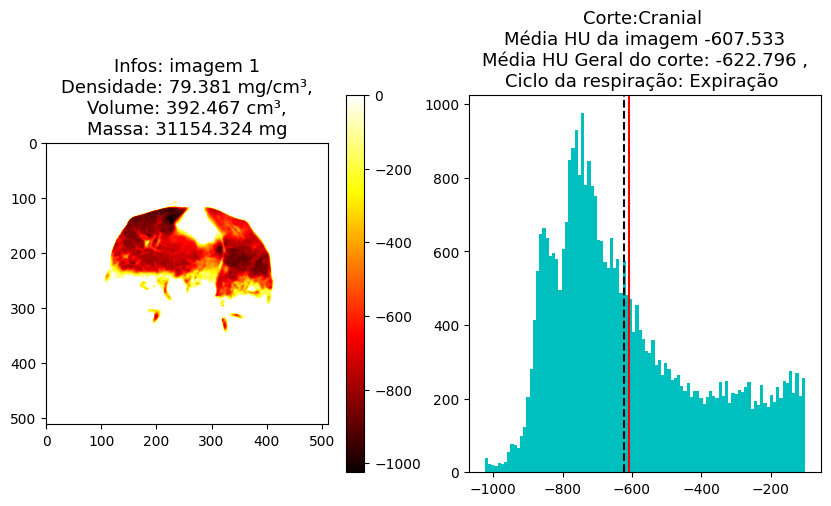

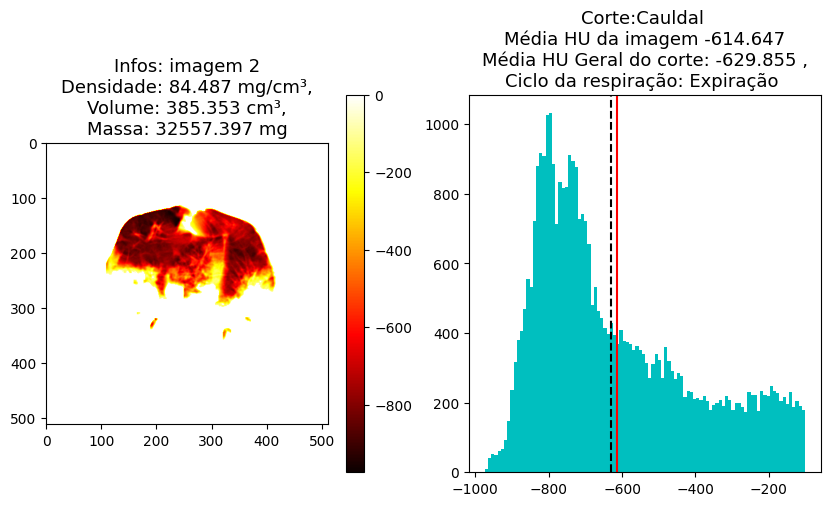

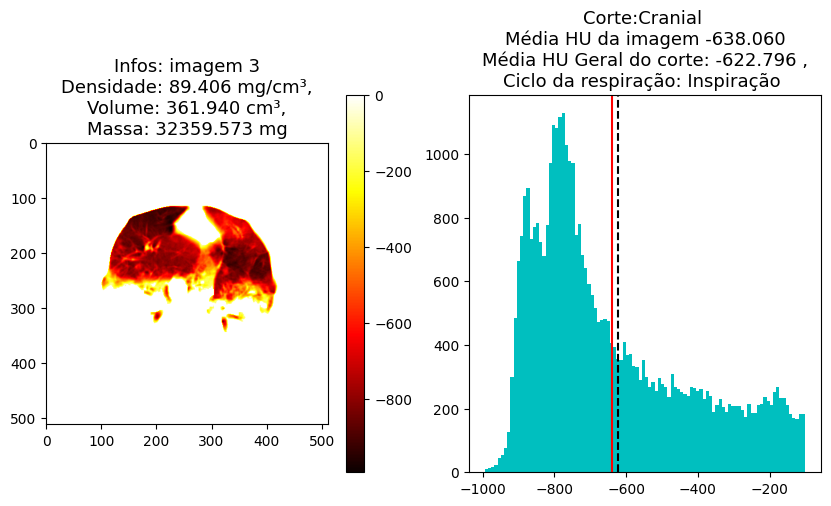

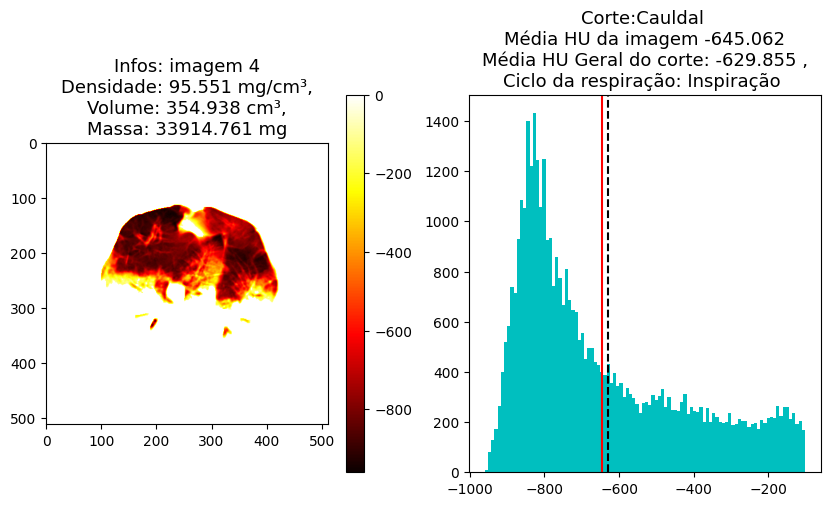

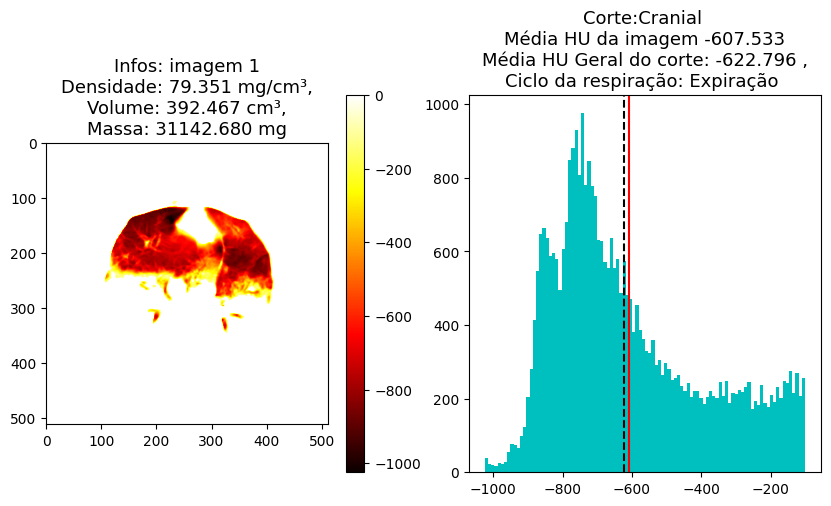

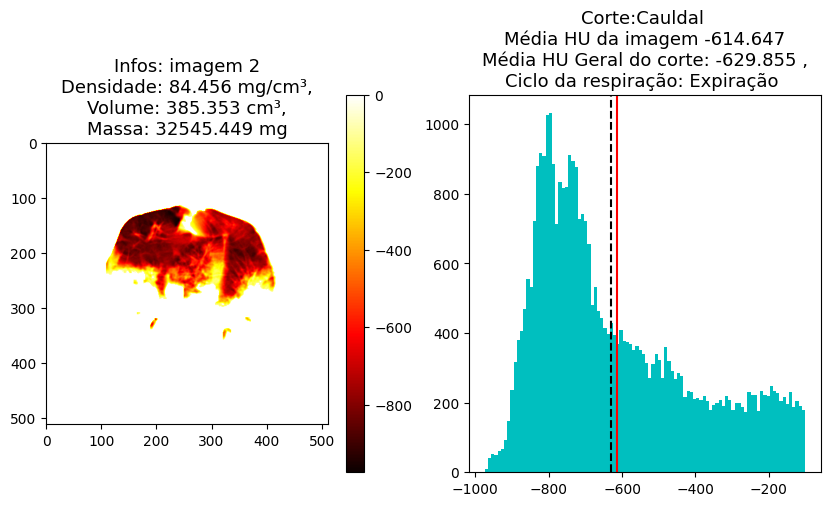

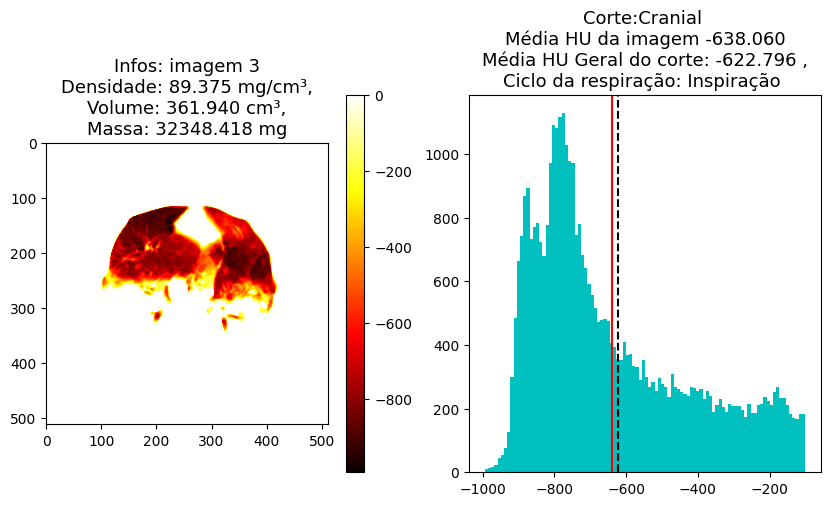

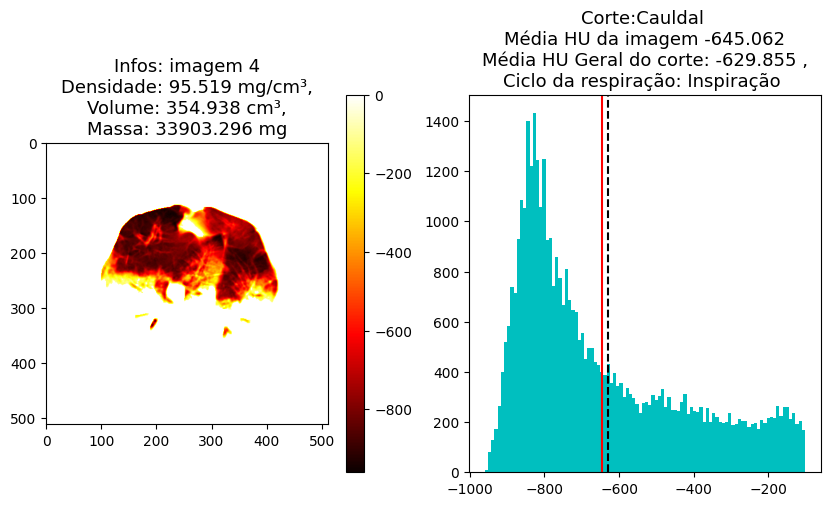

In [ ]:
caminho = input('Digite o caminho da pasta que contenha os arquivos\n')
df_ctq = programa_ctq(caminho)
df_formula = programa_formula(caminho)
analise(df_ctq)
analise(df_formula)

In [ ]:
programa_volume(caminho)

O volume do pulmão segmentado é: 48.226
Corte:Cranial 
Média HU da imagem -607.533
Média HU Geral do corte: -622.796 ,
Ciclo da respiração: Expiração 


O volume do pulmão segmentado é: 51.930
Corte:Cauldal 
Média HU da imagem -614.647
Média HU Geral do corte: -629.855 ,
Ciclo da respiração: Expiração 


O volume do pulmão segmentado é: 57.046
Corte:Cranial 
Média HU da imagem -638.060
Média HU Geral do corte: -622.796 ,
Ciclo da respiração: Inspiração 


O volume do pulmão segmentado é: 61.637
Corte:Cauldal 
Média HU da imagem -645.062
Média HU Geral do corte: -629.855 ,
Ciclo da respiração: Inspiração 
